<a href="https://colab.research.google.com/github/nestorjuarezR/Data_Science/blob/main/Proyecto_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Proyecto 4</h1>

<h3>Predicción Precio de propiedades registradas en Properati</h3>

Objetivos:
- Aplicar diferentes modelo de Machine Learning
- Aumentar la correlación de las variables seleccionadas para la resolución del problema
- Mejor el rendimiento de los modelos aplicados, en comparativa con los resultados aplicados en el proyecto 2
- Aplicar Redes Neuronales para la predicción de precio


Resultados obtenido en el proyecto 2:
- **Modelo Benchmark**:
        ->`DecisionTreeRegressor`: 
            R2 =  0.5350388799882471
            RMSE = 54284.76528901331
- **Modelo Final**
        ->`BaggingRegressor`:
            R2 = 0.7759767555983335
            RMSE = 0.4747605853333093
Emplare estos resultados como referencia a superar para el desarrollo de este proyecto

**Importante**

Repositorio GitHub:
https://github.com/nestorjuarezR/Data_Science

Proyecto 4 :
https://github.com/nestorjuarezR/Data_Science/blob/main/Proyecto_4.ipynb

Proyecto 2:
https://github.com/nestorjuarezR/Data_Science/blob/main/PY2_NJR.ipynb

# Librerias

In [ ]:
pip install Keras

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Geo Headmaps
import plotly.express as px

#Escalado de Datos
from sklearn.preprocessing import StandardScaler

#Polynomial
from sklearn.preprocessing import PolynomialFeatures

#Modelo Benchmark
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Models
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn import ensemble
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import VotingRegressor
from mlxtend.regressor import StackingRegressor


#Metricas
from sklearn import  metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Rede neuronales
import tensorflow as tf
from sklearn.neural_network import MLPRegressor

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import zscore

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
url = '/content/drive/MyDrive/Data/properati.csv'
data = pd.read_csv(url)

In [ ]:
def valores_nulos(dataset):
  print('<------------->')
  print('Porcentaje de Valores nulos\n')
  print(dataset.isnull().sum() / dataset.shape[0] * 100)

# Filtrado de Información

Empleo los mismo filtros de información solicitados desde el proyecto 1.

In [ ]:
data_ml=data[(data.l2 == 'Capital Federal') & (data.property_type.isin(['Departamento', 'Casa', 'PH']))]
data_ml = data_ml[(data_ml.surface_total >= 15)] 
data_ml = data_ml[(data_ml.surface_total <= 1000)]
data_ml = data_ml[(data_ml.price <= 4000000 )]
data_ml = data_ml[['lat', 'lon','l3','property_type','rooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']]

In [ ]:
valores_nulos(data_ml)

<------------->
Porcentaje de Valores nulos

lat                5.175239
lon                5.175239
l3                 0.000000
property_type      0.000000
rooms              0.000000
bathrooms          1.068311
surface_total      0.000000
surface_covered    0.627633
price              0.000000
dtype: float64


In [ ]:
#¿Presencia de valores invertidos?
datos_invertidos= data_ml.loc[data_ml.surface_total < data_ml.surface_covered]
print('Existen', len(datos_invertidos),'datos invertidos')

Existen 751 datos invertidos


Ya que no cuento con información que respalde que los usuarios realizaron un mal llenado de los datos en la plataforma, introduciendo los datos acerca de superficie cubierta en el campo correspondiente a superficie total. Por lo que en la data, se encuentran valores de superficie cubierta mayores a superficie total.
Ya que estos datos no representan un gran porcentaje de datos, decidido eliminarlos.


In [ ]:
#Limpieza de valores invertidos
data_ml = data_ml[(data_ml.surface_total >= data_ml.surface_covered)]

In [ ]:
#Comprobación 
datos_invertidos_2= data_ml.loc[data_ml.surface_total < data_ml.surface_covered]
print('Existen', len(datos_invertidos_2),'datos invertidos')

Existen 0 datos invertidos


In [ ]:
valores_nulos(data_ml)

<------------->
Porcentaje de Valores nulos

lat                5.240121
lon                5.240121
l3                 0.000000
property_type      0.000000
rooms              0.000000
bathrooms          1.022132
surface_total      0.000000
surface_covered    0.000000
price              0.000000
dtype: float64


Al eliminar la información correspondiente a valores invertidos, la presencia de valores nulos disminuye


In [ ]:
#Eliminar informacion duplicada
data_ml.drop_duplicates(inplace=True)

In [ ]:
#Copia
data_py2 = data_ml.copy()

#EDA

## Imputación de Valores faltantes

Para la imputación de valores faltantes, decido emplear la media correspondientes a los baños en función del tipo de propiedad.
Por lo que empleo mi dataset copia para obtener la media y así poder imputar en mis data de trabajo.


In [ ]:
valores_nulos(data_ml)

<------------->
Porcentaje de Valores nulos

lat                5.504110
lon                5.504110
l3                 0.000000
property_type      0.000000
rooms              0.000000
bathrooms          1.418028
surface_total      0.000000
surface_covered    0.000000
price              0.000000
dtype: float64


In [ ]:
#Elimino valores nulos en dataset copia
data_py2.dropna(inplace=True)

In [ ]:
#Agrupación segun el tipo de propiedad
mean_bt = data_py2.groupby('property_type')['bathrooms'].mean().round(0)

In [ ]:
mean_bt = dict(round(mean_bt))
mean_bt

{'Casa': 2.0, 'Departamento': 2.0, 'PH': 1.0}

In [ ]:
#Imputar valores
data_ml.bathrooms = data_ml.bathrooms.fillna(data_ml.property_type.map(mean_bt))

In [ ]:
valores_nulos(data_ml)

<------------->
Porcentaje de Valores nulos

lat                5.50411
lon                5.50411
l3                 0.00000
property_type      0.00000
rooms              0.00000
bathrooms          0.00000
surface_total      0.00000
surface_covered    0.00000
price              0.00000
dtype: float64


# Análisis Data

###Departamentos

In [ ]:
data_geo = data_ml.copy()
data_geo.dropna(axis=0, inplace=True)
data_geo.reset_index(drop=True, inplace=True)

In [ ]:
#Filtro exclusivo para datos de Departamentos
data_departamentos = data_geo[data_geo['property_type'] == 'Departamento']

In [ ]:
px.set_mapbox_access_token("pk.eyJ1IjoibmVzdG9yanIiLCJhIjoiY2tqeWp1ZnA0MDEzdjJwcWthOHloOWZ2diJ9.Gb5H_uqHOuk3vxxJPIpf0w")

In [ ]:
fig = px.scatter_mapbox(data_departamentos,
                        lat="lat",
                        lon="lon",
                        color="l3",
                        hover_name="property_type",
                        size="price",
                        hover_data=["price", "l3"],
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom=10,
                        height=1000)
fig.update_layout(mapbox_style="dark")
fig.show()

El gráfico, ayuda a una mejor comprensión de la ubicación de las propiedades en función de los barrios. Ya que si las personas  desean estudiar los datos y estas no son  de la región. les resulta algo confuso la ubicación de los barrios. Por lo que este gráfico ayuda a una mejor comprensión además de mostrar los barrio con mayores registros



In [ ]:
fig = px.scatter_mapbox(data_departamentos,
                        lat="lat",
                        lon="lon",
                        color="price",
                        hover_name="l3",
                        size="price",
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom=10,
                        height=1000)
fig.update_layout(mapbox_style="dark")
fig.show()

A partir del gráfico, se evidencia que los Departamentos con los precios más altos, son los que presentan mayor cercanía al mar. Teniendo diferentes variables que posiblemente afectan el precio como lo es la cercanía al puerto, Aeropuerto, parques, campos de golf y plazas comerciales.

In [ ]:
#Precio por metro cuadrado de las viviendad
data_departamentos['price_m2'] = (data_departamentos['price'] / data_departamentos['surface_total']).round(2)

In [ ]:
z = data_departamentos.l3.value_counts().head(10)
print('Regiones con mas registros de Departamentos')
for i in z.index:
  print('--> {}'.format(i))

Regiones con mas registros de Departamentos
--> Palermo
--> Belgrano
--> Recoleta
--> Caballito
--> Almagro
--> Villa Crespo
--> Villa Urquiza
--> Barrio Norte
--> Flores
--> Balvanera


In [ ]:
j = data_departamentos.price.value_counts().head(10)
print('Precios mas frecuentes en Departamentos')
for i in j.index:
  print('--> ${}'.format(i))

Precios mas frecuentes en Departamentos
--> $125000.0
--> $120000.0
--> $115000.0
--> $135000.0
--> $110000.0
--> $145000.0
--> $165000.0
--> $130000.0
--> $95000.0
--> $105000.0


In [ ]:
m2_price = data_departamentos.price_m2.sort_values(ascending=False).head(10)
print('Precio por metro cuadrado mas elevados')
for i in range(10):
  print('--> ${}'.format(m2_price.iloc[i]))

Precio por metro cuadrado mas elevados
--> $58333.33
--> $39632.93
--> $22222.22
--> $22200.0
--> $20491.8
--> $20202.02
--> $14787.23
--> $14666.67
--> $14255.32
--> $14084.54


In [ ]:
#Datos de propieades con mayor precio por metro cuadrado
data_departamentos.loc[[12934,41108,26882,6808,7053,42863,30986,17521,30983,16226]]

lat        lon  ...      price  price_m2
12934 -34.609558 -58.362674  ...  3150000.0  58333.33
41108 -34.593645 -58.399170  ...  3249900.0  39632.93
26882 -34.630894 -58.408096  ...  1000000.0  22222.22
6808  -34.633503 -58.453378  ...  1110000.0  22200.00
7053  -34.581464 -58.426407  ...  1250000.0  20491.80
42863 -34.688740 -58.477428  ...  1111111.0  20202.02
30986 -34.610849 -58.361958  ...  1390000.0  14787.23
17521 -34.610576 -58.361591  ...  1100000.0  14666.67
30983 -34.610849 -58.361958  ...  1340000.0  14255.32
16226 -34.575802 -58.404921  ...  3000007.0  14084.54

[10 rows x 10 columns]

###Casa

In [ ]:
data_casa = data_geo[data_geo['property_type'] == 'Casa']

In [ ]:
fig = px.scatter_mapbox(data_casa,
                        lat="lat",
                        lon="lon",
                        color="l3",
                        hover_name="property_type",
                        size="price",
                        hover_data=["price", "l3"],
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom=10,
                        height=1000,)
fig.update_layout(mapbox_style="dark")
fig.show()

De igual manera, el gráfico ayuda a una mejor comprensión de la dispersión de los datos, mostrando los barrios con mayor registros y la ubicación exacta de las propiedades registradas

In [ ]:
fig = px.scatter_mapbox(data_casa,
                        lat="lat",
                        lon="lon",
                        color="price",
                        hover_name="l3",
                        size="price",
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom=10,
                        height=1000)
fig.update_layout(mapbox_style="dark")
fig.show()

A diferencia de los departamentos, las casas presentan precios más equilibrados entre sí, siendo las casas más caras las que se encuentran con mayor cercanía al mar, dando mayor plusvalía la cercanía a parques, puertos,club de golf, plazas comerciales …

In [ ]:
#Precio por metro cuadrado de la vivienda
data_casa['price_m2'] = (data_casa['price'] / data_casa['surface_total']).round(2)

In [ ]:
z = data_casa.l3.value_counts().head(10)
print('Regiones con mas registros de Casas')
for i in z.index:
  print('--> {}'.format(i))

Regiones con mas registros de Casas
--> Villa Devoto
--> Flores
--> Mataderos
--> Villa Lugano
--> Caballito
--> Belgrano
--> Villa del Parque
--> Villa Urquiza
--> Parque Chacabuco
--> Nuñez


In [ ]:
j = data_casa.price.value_counts().head(10)
print('Precios mas frecuentes en Casa')
for i in j.index:
  print('--> ${}'.format(i))

Precios mas frecuentes en Casa
--> $250000.0
--> $350000.0
--> $320000.0
--> $260000.0
--> $280000.0
--> $450000.0
--> $220000.0
--> $420000.0
--> $180000.0
--> $330000.0


In [ ]:
m2_price = data_casa.price_m2.sort_values(ascending=False).head(10)
print('Precio por metro cuadrado mas elevados')
for i in range(10):
  print('--> ${}'.format(m2_price.iloc[i]))

Precio por metro cuadrado mas elevados
--> $6000.0
--> $5000.0
--> $4916.67
--> $4545.45
--> $4304.64
--> $4281.77
--> $4248.21
--> $4241.83
--> $4225.35
--> $4083.33


In [ ]:
#Datos de propieades con mayor precio por metro cuadrado
data_casa.loc[[39798,28320,30010,4275,41128,16047,38749,34258,9981,22428]]

lat        lon          l3  ... surface_covered      price  price_m2
39798 -34.576885 -58.401905     Palermo  ...           192.0  1200000.0   6000.00
28320 -34.577053 -58.413982     Palermo  ...           300.0  1500000.0   5000.00
30010 -34.568165 -58.441872    Belgrano  ...           550.0  2950000.0   4916.67
4275  -34.570165 -58.462383    Belgrano  ...           880.0  4000000.0   4545.45
41128 -34.642143 -58.510571     Liniers  ...           151.0   650000.0   4304.64
16047 -34.592067 -58.415244     Palermo  ...           362.0  1550000.0   4281.77
38749 -34.622993 -58.421955       Boedo  ...            56.0   237900.0   4248.21
34258 -34.571346 -58.447880    Belgrano  ...           153.0   649000.0   4241.83
9981  -34.559151 -58.481935       Nuñez  ...           290.0  1500000.0   4225.35
22428 -34.573823 -58.455261  Colegiales  ...            61.0   318500.0   4083.33

[10 rows x 10 columns]

###PH

In [ ]:
data_ph = data_geo[data_geo['property_type'] == 'PH']

In [ ]:
fig = px.scatter_mapbox(data_ph,
                        lat="lat",
                        lon="lon",
                        color="l3",
                        hover_name="property_type",
                        size="price",
                        hover_data=["price", "l3"],
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom=10,
                        height=1000)
fig.update_layout(mapbox_style="dark")
fig.show()

La presencia de registros de PH, se encuentra con buena dispersion por toda la Capital Federal

In [ ]:
fig = px.scatter_mapbox(data_ph, 
                        lat="lat",
                        lon="lon",
                        color="price",
                        hover_name="l3",
                        size="price",
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom=10,
                        height=1000)
fig.update_layout(mapbox_style="dark")
fig.show()

Los precios de los penthouse registrados no se presentan tan disparados como lo es en el caso de los Departamentos. Teniendo pocos registros de Penthouse elevados en función de la cercanía al mar.

In [ ]:
#Precio por metro cuadrado de la vivienda
data_ph['price_m2'] = (data_ph['price'] / data_ph['surface_total']).round(2)

In [ ]:
z = data_ph.l3.value_counts().head(10)
print('Regiones con mas registros de Penthouse')
for i in z.index:
  print('--> {}'.format(i))

Regiones con mas registros de Penthouse
--> Palermo
--> Caballito
--> Villa Urquiza
--> Villa Devoto
--> Almagro
--> Villa Crespo
--> Flores
--> Villa del Parque
--> Floresta
--> Saavedra


In [ ]:
j = data_ph.price.value_counts().head(10)
print('Precios mas frecuentes en Penthouse')
for i in j.index:
  print('--> ${}'.format(i))

Precios mas frecuentes en Penthouse
--> $120000.0
--> $150000.0
--> $175000.0
--> $130000.0
--> $110000.0
--> $220000.0
--> $125000.0
--> $145000.0
--> $155000.0
--> $250000.0


In [ ]:
m2_price = data_ph.price_m2.sort_values(ascending=False).head(10)
print('Precio por metro cuadrado mas elevados')
for i in range(10):
  print('--> ${}'.format(m2_price.iloc[i]))

Precio por metro cuadrado mas elevados
--> $5557.69
--> $5322.58
--> $5151.52
--> $5000.0
--> $4903.85
--> $4852.94
--> $4743.59
--> $4487.18
--> $4421.05
--> $4348.84


In [ ]:
#Datos de propieades con mayor precio por metro cuadrado
data_ph.loc[[47064,36912,36997,8898,31073,8383,24384,8930,25011,1372]]

lat        lon            l3  ... surface_covered     price  price_m2
47064 -34.582045 -58.469325   Parque Chas  ...            44.0  289000.0   5557.69
36912 -34.579309 -58.430957       Palermo  ...            50.0  330000.0   5322.58
36997 -34.599532 -58.391948  Barrio Norte  ...            33.0  170000.0   5151.52
8898  -34.577070 -58.439040       Palermo  ...           118.0  590000.0   5000.00
31073 -34.598020 -58.500930  Villa Devoto  ...            52.0  255000.0   4903.85
8383  -34.584160 -58.441956       Palermo  ...            34.0  165000.0   4852.94
24384 -34.585613 -58.437803       Palermo  ...            39.0  185000.0   4743.59
8930  -34.585613 -58.437803       Palermo  ...            39.0  175000.0   4487.18
25011 -34.559519 -58.481781       Coghlan  ...            75.0  420000.0   4421.05
1372  -34.588977 -58.390592      Recoleta  ...            35.0  187000.0   4348.84

[10 rows x 10 columns]

### Similitud en propiedades

Text(0.5, 1.0, 'Relacion de tipos de propiedad')

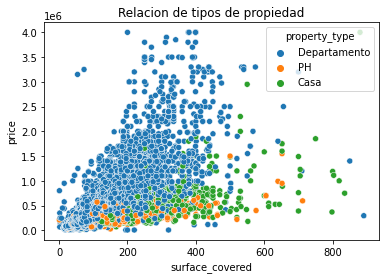

In [ ]:
sns.scatterplot(data=data_ml, x='surface_covered', y='price', hue='property_type')
plt.title('Relacion de tipos de propiedad')

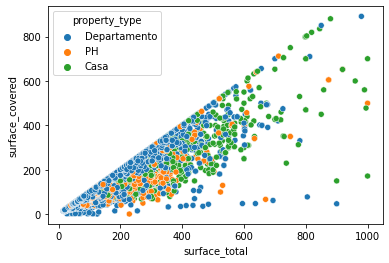

In [ ]:
sns.scatterplot(x='surface_total', y='surface_covered', data=data_ml, hue='property_type')

Con base en ambos gráficos presentados, existe una similitud entre los tres tipos de propiedad (Casa, Departamento y PH). No se logra una completa diferenciación en el precio si la propiedad es un departamento, casa o penthouse. Por lo que `property_type` no es una variable completamente dependiente del precio de la propiedad.

Al graficar la superficie cubierta y el precio de la propiedad, se logra una mejor distinción del tipo de propiedad, Siendo Casa y PH las que presentan mayor similitud.

Al graficar `Surface_total` y `Surface_covered` se presenta la misma problemática, en donde se presenta similitud entre los registros de Casa y PH


#Modelo Benchmark

In [ ]:
#Defino la formula de mi regresion para predecir el precio
reg = smf.ols('price ~ rooms + bathrooms + surface_total + surface_covered', data= data_ml)

In [ ]:
#Entreno el modelo
res = reg.fit()

In [ ]:
#Informe
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                 1.941e+04
Date:                Sat, 16 Jan 2021   Prob (F-statistic):               0.00
Time:                        20:12:21   Log-Likelihood:            -6.7715e+05
No. Observations:               49999   AIC:                         1.354e+06
Df Residuals:                   49994   BIC:                         1.354e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -2.241e+04   2244.095     

Dado el informe del modelo, las métricas globales para la regresión lineal aplicada, obtuvo un R2 de 0.6
Esta métrica es más baja que la obtenida en el proyecto 2.
Ya que en el proyecto 2 en mi modelo final seleccionado `BaggingRegressor` obtuve un valor de R2 de 0.77.
Tomando estas métricas como refencia a superar para la aplicación de modelo más complejos y de un mejor procesamiento de la información




# Aumento de Correlación

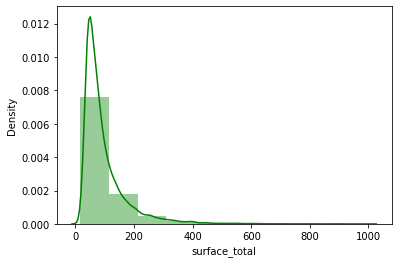

In [ ]:
sns.distplot(data_ml.surface_total,
             kde=True,
             color='green',
             bins=10)

Ya que los datos de superficie total , presentan asimetría. Además de presentar varios valores atípicos, y estos afectan directamente al rendimiento del modelo.


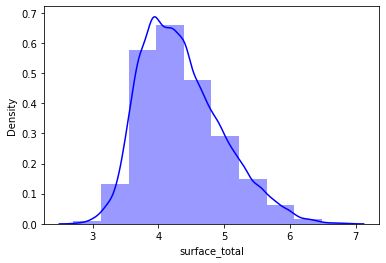

In [ ]:
sns.distplot(np.log(data_ml.surface_total), 
             kde=True, 
             color='blue',
             bins=10)

Aplico logaritmo a los datos con el fin de modificar la simetría y como consecuencia los outlier reduzcan.

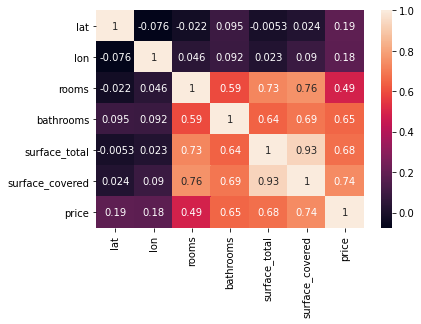

In [ ]:
sns.heatmap(data_ml.corr(), annot=True)

Correlación de variables.
En donde rooms es la variable que presenta menor relación, por lo que es de considerarse descartarla.

In [ ]:
columnas = ['rooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']

for i in columnas:
  data_ml[i]= data_ml[i].map(np.log)

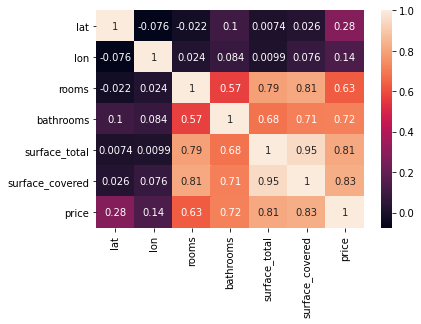

In [ ]:
sns.heatmap(data_ml.corr(), annot=True)

Al aplicar logaritmo a las variables, su correlación aumenta. Siendo Room la que se ve más favorecida.

#Divison Datos X e Y

In [ ]:
#Separo datos en X e Y
X = data_ml[['rooms', 'bathrooms', 'surface_total', 'surface_covered']]
Y = data_ml[['price']]

In [ ]:
X.shape, Y.shape

((49999, 4), (49999, 1))

# Polynomial Features

Polynomial Features ayuda a mejorar la linealidad de los datos, adecuandolos a una regresión lineal. Por lo que al aplicarlos. Los datos tendrán una dispersión cercana a la lineal

In [ ]:
poly = PolynomialFeatures(degree=4)

In [ ]:
features_poly = poly.fit_transform(X)

In [ ]:
poly_df = pd.DataFrame(features_poly, columns=poly.get_feature_names())

In [ ]:
poly_df.head(2)

1        x0        x1  ...   x2^2 x3^2     x2 x3^3        x3^4
0  1.0  1.945910  0.693147  ...  596.328089  596.328089  596.328089
1  1.0  0.693147  0.693147  ...  297.589163  284.416897  271.827679

[2 rows x 70 columns]

In [ ]:
poly_df.shape

(49999, 70)

# Escalado de Datos

- Realizare el escalado de datos con el fin de establecer todos mis datos dentro de un mismo rango de valores y optimizar el rendimiento del modelo.

In [ ]:
#Defino el modelo
std = StandardScaler()

In [ ]:
#Entreno modelo
std.fit(poly_df)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
#Transformo datos
data_escalada = std.transform(poly_df)

In [ ]:
#Conversion a DataFramde
data_escalada = pd.DataFrame(data_escalada)

#Enconding

- Encoding: Realizare Encoding de Variables Categóricas, como lo es los tipos de Barrios presente en la columna L3, esta información puede influir en mejorar el rendimiento al momento de realizar las predicciones.Al convertirla a una variable numérica puede afectar positivamente al modelo ya que este cuenta con mayor información en la cual se basa para realizar las predicciones.


In [ ]:
#Selecciono datos de barrios
l3 = data_ml['l3']

In [ ]:
l3_get = pd.get_dummies(l3, prefix=('x'))

In [ ]:
#Reseteo Index
data_escalada.reset_index(drop=True, inplace=True)
l3_get.reset_index(drop=True, inplace=True)

In [ ]:
poly_df.shape, l3_get.shape

((49999, 70), (49999, 57))

In [ ]:
#Union de DataFrames
data_eda = pd.merge(poly_df, l3_get, how='left', left_index=True, right_index=True)

#Modelos

Aplico diferentes modelos de Machine Learning exclusivos a la resolución de regresión lineal, con el fin de tener diferentes opciones, seleccionando los modelos que presenten mejores resultados. Con el fin de ensamblar un modelo final agrupando exclusivamente los mejores modelos 


In [ ]:
#Division datos entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(data_eda, Y,
                                                    test_size=0.25,
                                                    random_state=40)

In [ ]:
def evaluar_modelo(modelo,X_train,X_test,y_train,y_test):
    modelo.fit(X_train,y_train)
    print ("* R2 del modelo  en train:", modelo.score(X_train,y_train) )
    print('RMSE en train:',np.sqrt(mean_squared_error(y_train, modelo.predict(X_train))))
    print ("* R2 del modelo en test:", modelo.score(X_test,y_test) )
    print('RMSE en test:',np.sqrt(mean_squared_error(y_test, modelo.predict(X_test))))

In [ ]:
def graficos_prediccion(modelo):
  y_pred = modelo.predict(X_test)
  sns.distplot(y_test, kde=True, color='red', bins=50, label='Real price')
  sns.distplot(y_pred, kde=True, color='blue', bins=50, label='Predict price')
  
  plt.xlabel('Sale Price')
  plt.ylabel('Count')
  plt.legend(loc='upper right')
  plt.title('Comparativa de precios')

In [ ]:
def graficos(model):

  #Grafico de error
  y_train_pred_1 = model.predict(X_train)
  y_test_pred_1 = model.predict(X_test)
  rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_1))
  rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_1))
  plt.figure(figsize = (15,6))
  plt.subplot(1,2,1)
  sns.distplot(y_train - y_train_pred_1, bins = 20, label = 'train')
  sns.distplot(y_test - y_test_pred_1, bins = 20, label = 'test')
  plt.xlabel('errores')
  plt.legend()
  plt.title('Error')
  
  #Comparativa predicciones
  plt.subplot(1,2,2)
  sns.distplot(y_test, kde=True, color='red', bins=50, label='Real price')
  sns.distplot(y_test_pred_1, kde=True, color='blue', bins=50, label='Predict price')
  plt.xlabel('Sale Price')
  plt.xticks(fontsize=14)
  plt.ylabel('Count')
  plt.legend(loc='upper right')
  plt.title('Comparativa de precios')

In [ ]:
def graficos_lineal(model,X_test,y_test):
    y_pred = model.predict(X_test)
    
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    sns.distplot(y_pred, label='Predicciones', color='blue')
    sns.distplot(y_test, label='Valor real', color='red')
    plt.legend()

    plt.subplot(1,2,2)
    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_pred, s =2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

In [ ]:
def get_random_sample(model, numero_muestra):
  
  #Tomo una muestra de mis datos en Test
  idxs = np.random.randint(X_test.shape[0], size=numero_muestra)

  muestra = X_test.iloc[idxs]
  prediccion = model.predict(muestra)

  valor_data = []
  for i in idxs:
    valor_real = y_test.price.iloc[i]
    valor_data.append(valor_real)

  valor_data = pd.DataFrame((valor_data), columns = ['valor_real'])
  prediccion = pd.DataFrame((prediccion), columns = ['valor_predicho'])
  comparacion = pd.merge(valor_data, prediccion, right_index=True, left_index=True)

  #Grafico
  r = comparacion['valor_real']
  p = comparacion['valor_predicho']
  plt.figure(figsize=(15,4))
  plt.plot(r,'o-',label='Valores reales')
  plt.plot(p,'o-',label='Valores predichos')
  plt.legend()
  plt.title('Comparacion de valores de propiedad')
  plt.xlabel('Muestra')
  plt.ylabel('Precio')

##LinearRegression

In [ ]:
linear = LinearRegression()

In [ ]:
evaluar_modelo(linear, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.8689272098825236
RMSE en train: 0.2504201067521666
* R2 del modelo en test: 0.862227892311509
RMSE en test: 0.255588126282644


`LinearRegression` es un modelo básico para la aplicación de problemas de regresión lineal.Obteniendo buenas métricas, superando el rendimiento del modelo aplicado en el proyecto 2.

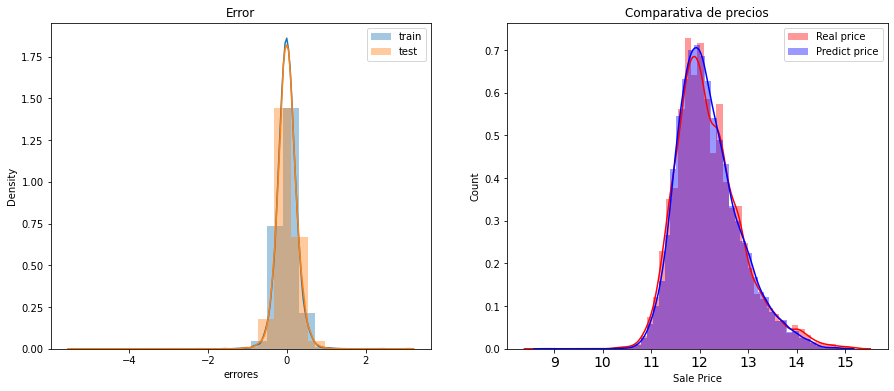

In [ ]:
graficos(linear)

El modelo presenta buenos resultados al ser evaluado con los datos de Test, presentando problemas para la predicción del precio en propiedades con precio real elevado.

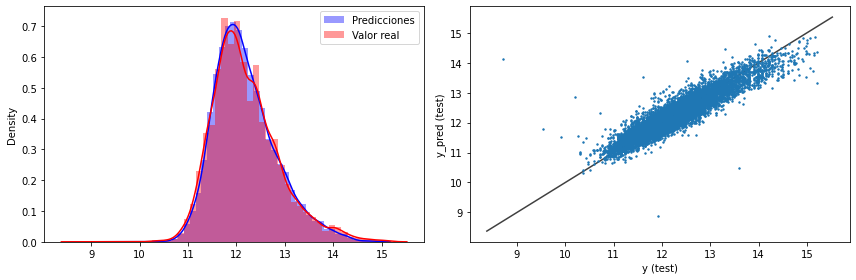

In [ ]:
graficos_lineal(linear, X_test, y_test)

Los datos predichos presentan buen ajuste a la linealidad. Sin embargo, con base en el gráfico, existen varios datos muy dispersos. Por lo que posiblemente, pertenezcan a las propiedades con precios elevados

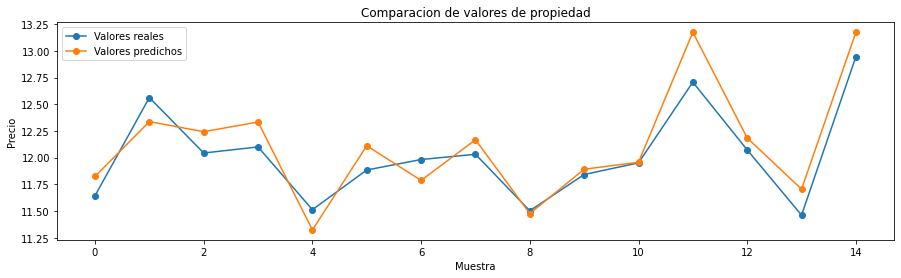

In [ ]:
get_random_sample(linear, 15)

El modelo presenta un buen ajuste sin llegar a ser perfecto, para la predicción de precios. Ajustándose a propiedades con valores bajos y valores altos. Teniendo la tendencia a subvalorar las propiedades costosas.

El gráfico proporciona una idea de la cercanía de los datos reales y predichos. Ya que los datos son seleccionados aleatoriamente. Este no representa fielmente el rendimiento global del modelo.

##RidgeCV

In [ ]:
ridge = RidgeCV()

In [ ]:
evaluar_modelo(ridge, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.867290709015414
RMSE en train: 0.251978559397592
* R2 del modelo en test: 0.8625886800809918
RMSE en test: 0.2552532489226147


El modelo `Ridge` fue aplicado en el proyecto 2. Con lo cual se comprueba la mejora en el rendimiento del modelo, gracias al procesamiento de la data.
Presentando un mejor R2 y RMSE, en comparación al proyecto 2


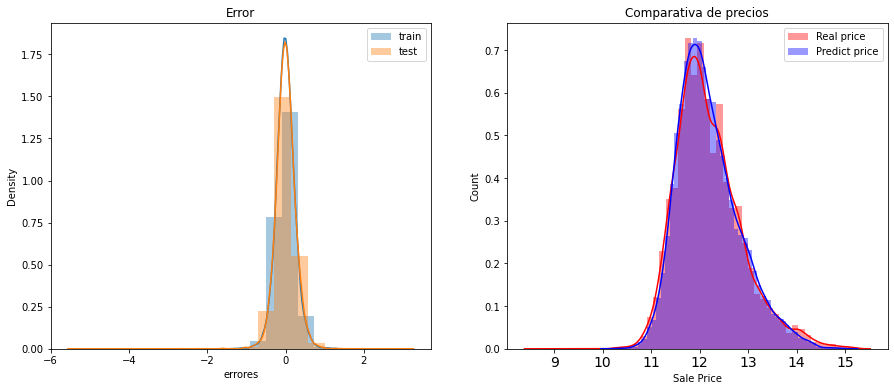

In [ ]:
graficos(ridge)

Con base en el gráfico de comparativa de precios reales y predichos. El modelo `Ridge` se observa que tiene tendencia a sobrevalorar las propiedades.

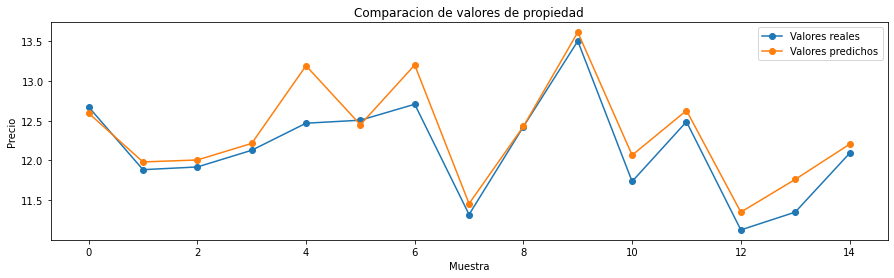

In [ ]:
get_random_sample(ridge, 15)

El modelo presenta un buen ajuste a las diferentes variables presentadas para la predicción del precio.

##LassoCV

In [ ]:
lasso = LassoCV()

In [ ]:
evaluar_modelo(lasso, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.7469566350877441
RMSE en train: 0.3479448407579459
* R2 del modelo en test: 0.7469553452928123
RMSE en test: 0.3463846250854552


Lasso, se aplicó en el proyecto 2. Caso contrario al modelo `Ridge`, este no presentó un mejor rendimiento. Ya que no es sensible al procesamiento realizado a la data.
Por lo que este modelo se descarta para el ensamble final.


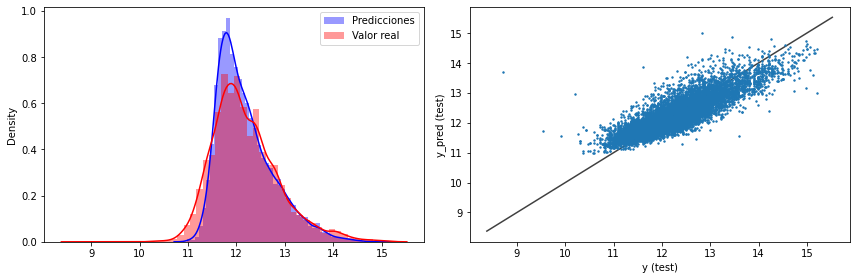

In [ ]:
graficos_lineal(lasso, X_test, y_test)

`Lasso` tiene la tendencia a sobrevalorar las propiedades, asignando un valor elevado a ellas.

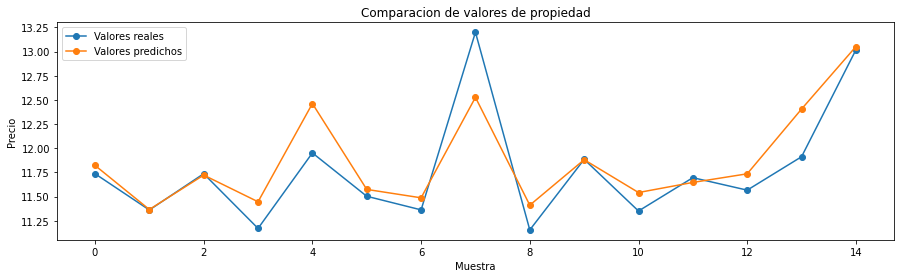

In [ ]:
get_random_sample(lasso, 15)

EL gráfico, ayuda a la mejor visualización a la sobrevaloración del precio de las propiedades del modelo `Lasso`.


##GradientBoostingRegressor

In [ ]:
#Defino el modelo
clf = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'ls')

In [ ]:
evaluar_modelo(clf, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.9104051962402411
RMSE en train: 0.2070400364753905
* R2 del modelo en test: 0.8793322071702616
RMSE en test: 0.23919698843406573


`GradientBoostingRegressor` presenta un buen score en las métricas globales, siendo evaluado con los datos de test. Obteniendo un buen R2.

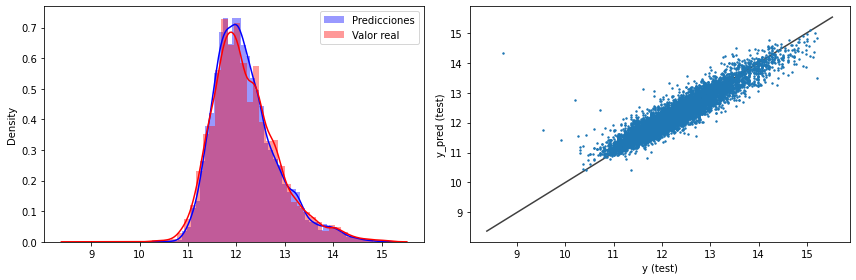

In [ ]:
graficos_lineal(clf, X_test, y_test)

El modelo sobrevalora las propiedades, sin embargo esto no es una tendencia. Se requiere de un análisis a detalle para identificar el tipo de propiedades que presentan esta problemática.


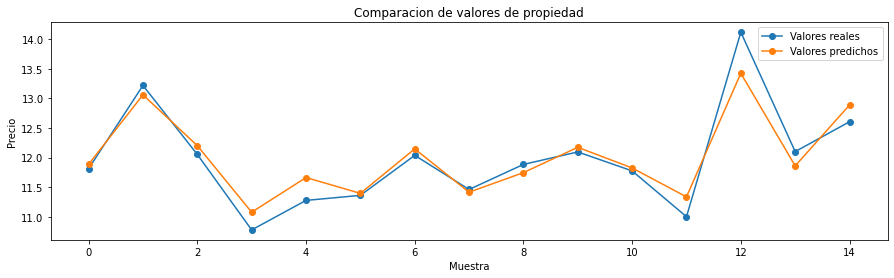

In [ ]:
get_random_sample(clf, 15)

El modelo, realiza buenas predicciones.
El gráfico proporciona una mejor visualización del problema de sobrevalorar algunas propiedades.

##ExtraTreesRegressor

In [ ]:
tree_reg = ExtraTreesRegressor(n_estimators=100, random_state=40)

In [ ]:
evaluar_modelo(tree_reg, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.9816847948888012
RMSE en train: 0.09360926118192388
* R2 del modelo en test: 0.8735149540996192
RMSE en test: 0.24489482859402767


`ExtraTreesRegressor` presenta un score de los más altos. Con un número relativamente bajo de `n_estimators`

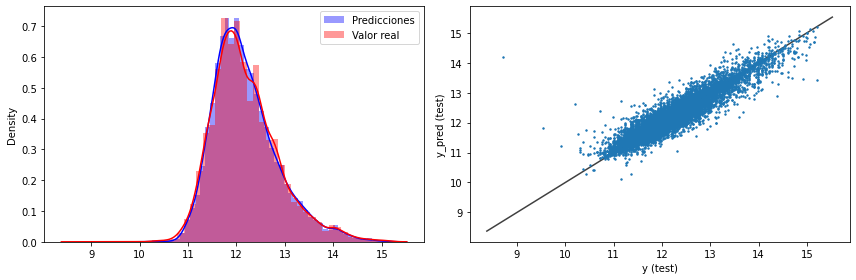

In [ ]:
graficos_lineal(tree_reg, X_test, y_test)

El modelo presenta buenas predicciones.

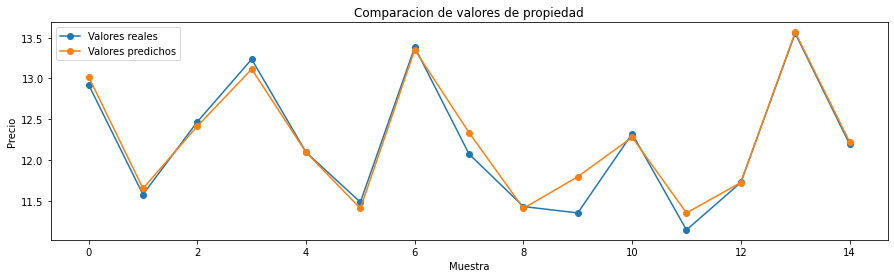

In [ ]:
get_random_sample(tree_reg, 15)

El modelo presenta un buen ajuste a las diferentes variables para la predicción del precio de las propiedades.

##BayesianRidge

In [ ]:
bay_reg = linear_model.BayesianRidge()

In [ ]:
evaluar_modelo(bay_reg, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.8678571628031114
RMSE en train: 0.25144021409693956
* R2 del modelo en test: 0.8629745819633773
RMSE en test: 0.2548945740892498


El rendimiento es similar siendo evaluado en datos de Entrenamiento y de Test

Presenta un buen rendimiento. Ya que se encuentra cercano al rendimiento de los demás modelos aplicados.




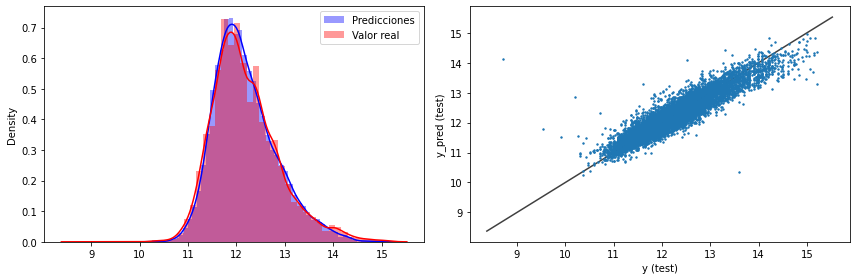

In [ ]:
graficos_lineal(bay_reg, X_test, y_test)

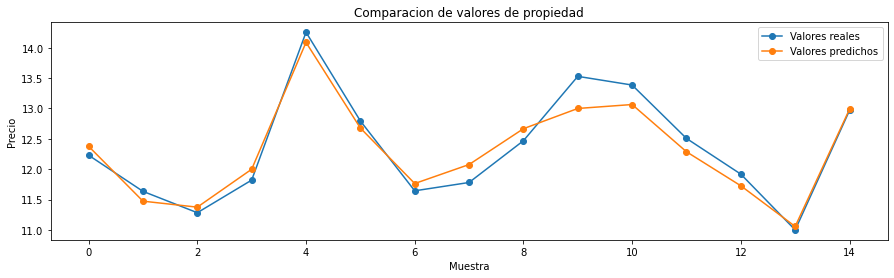

In [ ]:
get_random_sample(bay_reg, 15)

El gráfico proporciona una idea de la cercanía de los datos reales y predichos. Ya que los datos son seleccionados aleatoriamente. Este no representa fielmente el rendimiento global del modelo.

##RandomForestRegressor

In [ ]:
regg = RandomForestRegressor(n_estimators=150)

In [ ]:
evaluar_modelo(regg, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.9699003507754964
RMSE en train: 0.1200034250217704
* R2 del modelo en test: 0.8799738548730335
RMSE en test: 0.23856017901498047


`RandomForestRegressor` presenta el mejor score siendo evaluado con los datos de test, obteniendo el mejor rendimiento de los modelos aplicados.

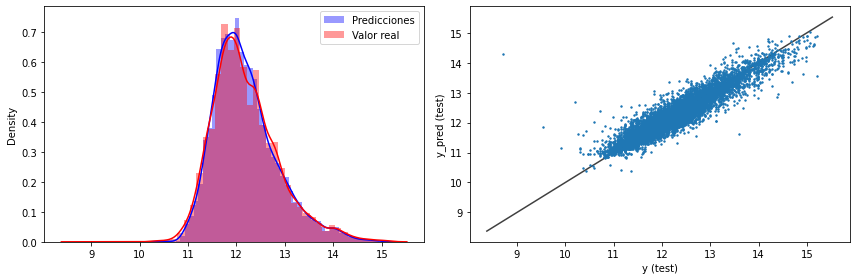

In [ ]:
graficos_lineal(regg, X_test, y_test)

No se observa ninguna tendencia en las predicciones realizadas. Siendo cercano a los precios reales

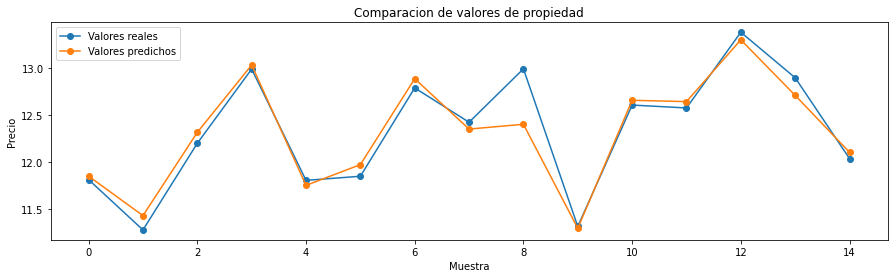

In [ ]:
get_random_sample(regg, 15)

##XGBRegressor

In [ ]:
xg_reg = XGBRegressor()

In [ ]:
evaluar_modelo(xg_reg, X_train, X_test, y_train, y_test)

[20:32:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
* R2 del modelo  en train: 0.8576303342124049
RMSE en train: 0.2609886716603154
* R2 del modelo en test: 0.8515212952951321
RMSE en test: 0.2653335135831181



El rendimiento es muy similar en los datos de entrenamiento y Test. Sin embargo estos resultados no son óptimos en comparación con los demás modelos aplicados. Por lo que se descarta para el ensamble final.


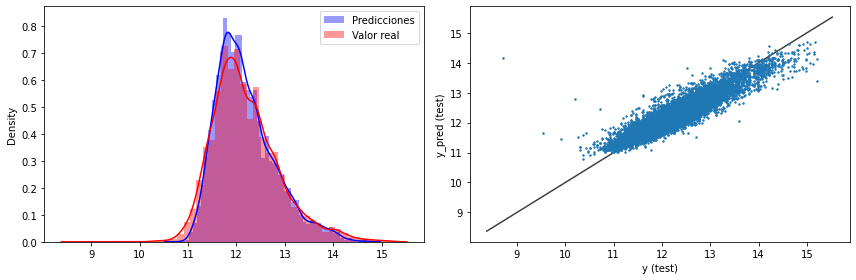

In [ ]:
graficos_lineal(xg_reg, X_test, y_test)

El modelo tiende a sobrevalorar las propiedades.


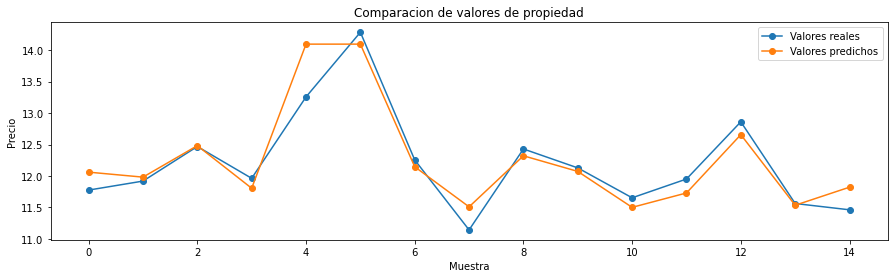

In [ ]:
get_random_sample(xg_reg, 15)

El gráfico ayuda a la visualización de la tendencia del modelo a sobrevalorar las propiedades.


##ElasticNetCV

In [ ]:
elas = ElasticNetCV(cv=5, max_iter=1e7)

In [ ]:
evaluar_modelo(elas, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.7461627804959134
RMSE en train: 0.34849020441414524
* R2 del modelo en test: 0.7465903638251292
RMSE en test: 0.34663434072284605


`ElasticNetCV` presenta uno de los rendimientos más bajos. Por lo que se descarta para el ensamble final


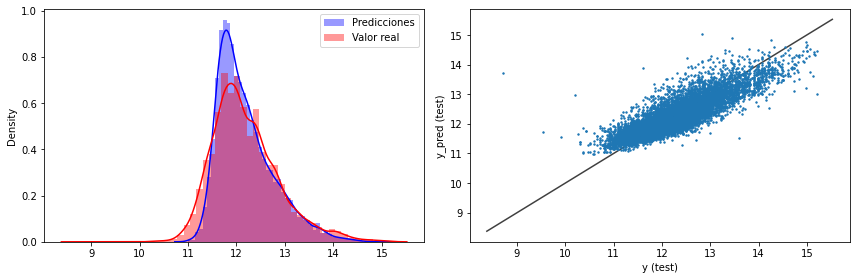

In [ ]:
graficos_lineal(elas, X_test, y_test)

El modelo `ElasticNetCV` presenta tendencia a sobrevalorar las propiedades.

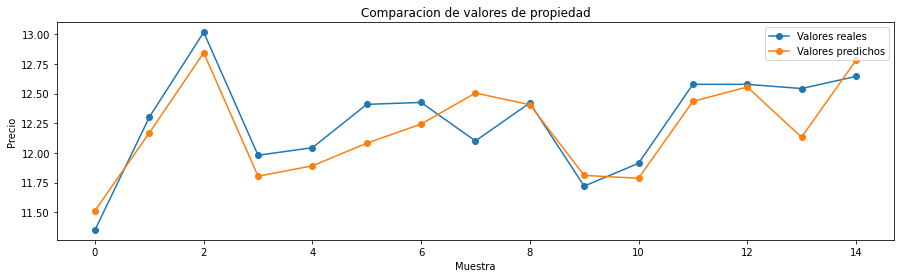

In [ ]:
get_random_sample(elas, 15)

Gran dispersión entre los datos reales y datos predichos por el modelo.


##Voting

En este modelo, empleo los modelos anteriores que obtuvieron los score más alto.
Definiendo el nombre del modelo y como está definido para realizar el ensamble en un único modelo.


In [ ]:
vote_mod = VotingRegressor([('RidgeCV', ridge),
                            ('GradientBoostingRegressor', clf),
                            ('ExtraTreesRegressor', tree_reg), 
                            ('RandomForestRegressor', regg),
                            ('BayesianRidge', bay_reg)])

In [ ]:
evaluar_modelo(vote_mod, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.9409417940301131
RMSE en train: 0.16809432411999495
* R2 del modelo en test: 0.8876104121621753
RMSE en test: 0.2308463766169865


El ensamble del modelo `VotingRegressor` presenta un buen score. No presentando una relativa diferencia entre los datos de entrenamiento y test además de presentar un RMSE bajo.

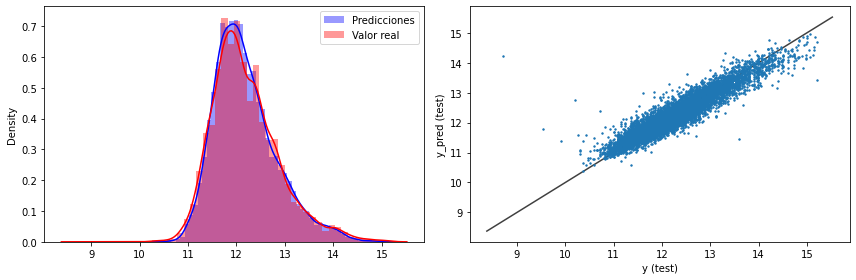

In [ ]:
graficos_lineal(vote_mod, X_test, y_test)

El modelo no presenta alguna tendencia en cuanto a sobrevalorar o subestimar los precios. 


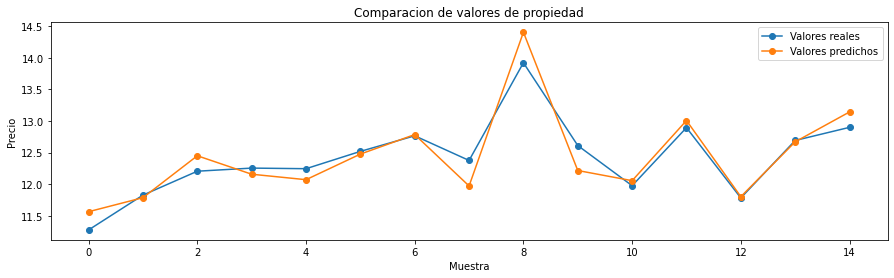

In [ ]:
get_random_sample(vote_mod, 15)

Presenta un muy buen ajuste a las variables para la predicción del precio. La cercanía entre datos reales y predichos es muy buena.

##StackingRegressor

De igual manera, empleo , del total de los modelos anteriores, solo los que obtuvieron un score mas alto. Definiendo el nombre del modelo, para realizar un ensamble en un único modelo. Estableciendo como meta estimador a `RandomForestRegressor`

In [ ]:
stregr = StackingRegressor(regressors=[ridge,tree_reg, clf, bay_reg], 
                           meta_regressor=regg,
                           use_features_in_secondary=True
                          )

In [ ]:
evaluar_modelo(stregr, X_train, X_test, y_train, y_test) 

* R2 del modelo  en train: 0.9816328435581321
RMSE en train: 0.09374192914696916
* R2 del modelo en test: 0.8734953705004987
RMSE en test: 0.2449137863154432


`StackingRegressor` muestra una buena puntuacion en las metricas globales.Sin embargo el modelo `VotingRegressor` presenta mejor puntuacion

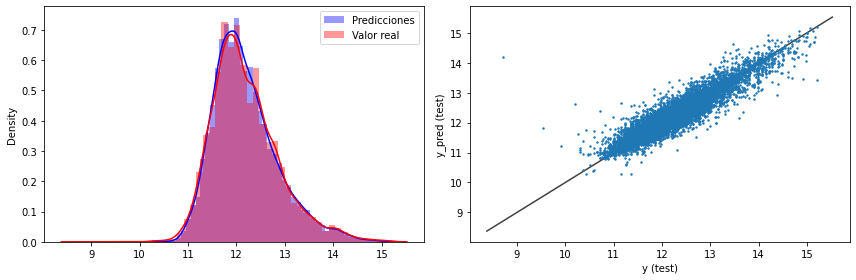

In [ ]:
graficos_lineal(stregr, X_test, y_test)

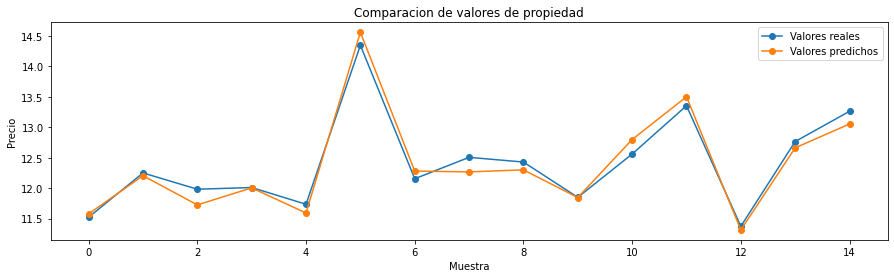

In [ ]:
get_random_sample(stregr, 15)

Presenta buen ajuste para realizar las predicciones.


# Red neuronal

##MLPRegressor

Esta red neuronal, funciona similar a un modelo de Machine Learning, ya que su estructura se encuentra definida, presentando hyper parámetros por default,  que pueden ser modificados en busca de una mejor optimización.

In [ ]:
#Defino el modelo
mlpr = MLPRegressor(
    solver='adam',
    alpha=1e-5,
    hidden_layer_sizes=(8,3),
    random_state=40)

In [ ]:
evaluar_modelo(mlpr, X_train, X_test, y_train, y_test)

* R2 del modelo  en train: 0.8555418122340824
RMSE en train: 0.2628960163875949
* R2 del modelo en test: 0.8548032966788681
RMSE en test: 0.262384635790114


El rendimiento de la red neuronal, no es superior a la mayoría de modelos de Machine Learning probados.
Como prueba inicial al emplear redes neuronales para la resolución de la problemática. Su rendimiento es bueno


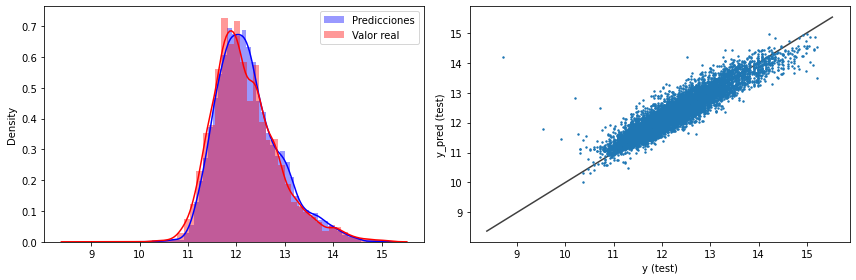

In [ ]:
graficos_lineal(mlpr, X_test, y_test)

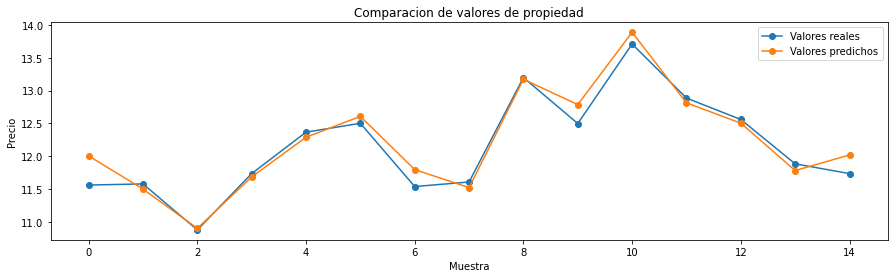

In [ ]:
get_random_sample(mlpr, 15)

## KerasRegressor

##Keras

In [ ]:
#Prueba de funcionalidad en Google Colab
try:
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab


In [ ]:
print(tf.__version__)

2.4.0


In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(X_train.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
#Construir el modelo
model = build_model()

In [ ]:
#Reporte
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                8192      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 12,417
Trainable params: 12,417
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  X_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

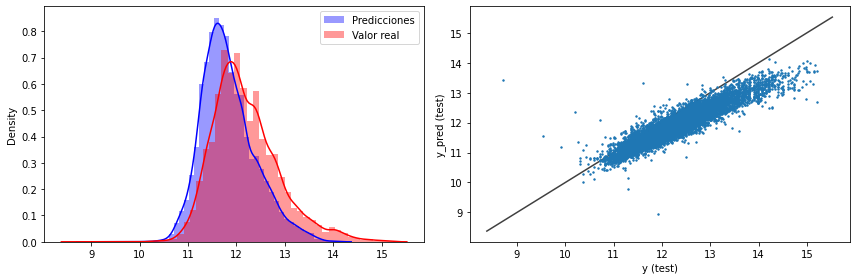

In [ ]:
graficos_lineal(model, X_test, y_test)

La dispersión de los datos predichos por la red neuronal, no tiene gran apego a los precios reales. Presentando mayor diferencia en comparación de los modelos de Machine Learning

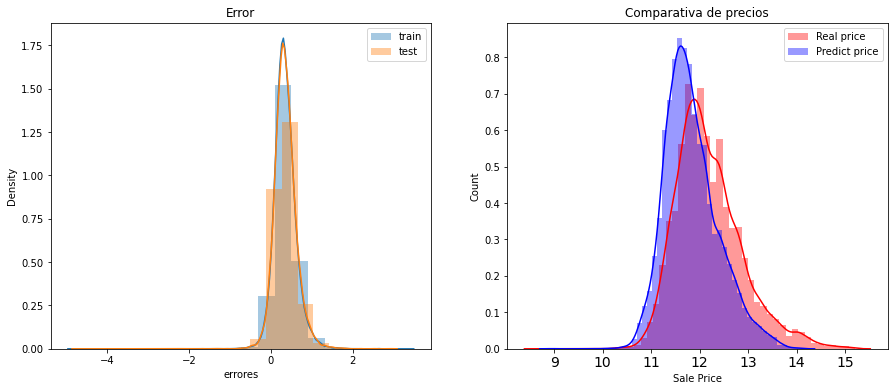

In [ ]:
graficos(model)

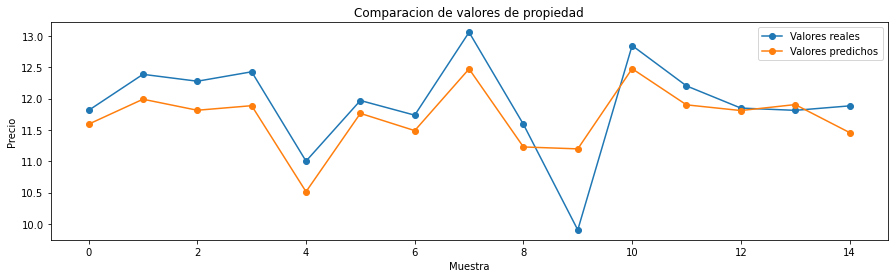

In [ ]:
get_random_sample(model, 15)

In [ ]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

391/391 - 0s - loss: 0.2016 - mae: 0.3739 - mse: 0.2016
Testing set Mean Abs Error:  0.37 MPG


#Conclusión

El procesamiento de la data, resultó apropiado. Aumentando la correlación de las variables para la predicción del precio.

Gran parte de los modelos probados en este proyecto, presentaron sensibilidad al procesamiento de los datos, teniendo como resultado un mejor rendimiento al realizar las predicciones.

Al aplicar diversos modelos de Machine Learning, obtuve una comparativa de los mejores modelos. A partir de la cual, realice un ensamble que agrupe a los modelos de Machine Learning con mejores rendimientos globales. El cual presentó puntuaciones globales muy buenas. Siendo este mi mejor modelo. El cual **Seleccionaria `VotingRegressor` como mi modelo Final**

Se aplicaron dos  redes neuronales, la primera tiene la estructura similar a un modelo de Machine Learnig, siendo más amigables y sencilla de emplear, sin embargo esta no obtuvo puntuaciones globales superiores a los modelos de Machine Learning.
La segunda, requirió de la construcción de las capas de la red neuronal, siendo más compleja de emplear. Su rendimiento no es superior a los modelos de Machine Learning. Sin embargo se requiere de un mejor conocimiento en redes neuronales para la construcción de una con parámetros optimizados. Siendo este mi primer contacto con redes neuronales. Se logró aplicarlas para la predicción de las propiedades.


# Referencias
- https://medium.com/@manilwagle/predicting-house-prices-using-machine-learning-cab0b82cd3f

- https://towardsdatascience.com/predicting-house-prices-with-linear-regression-machine-learning-from-scratch-part-ii-47a0238aeac
- https://github.com/traintestbritt/predicting_house_prices/blob/master/notebook-house_price_predictions-brittany_allen.ipynb
- https://github.com/Shreyas3108/house-price-prediction/blob/master/housesales.ipynb
- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neural_network
- https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_3_keras_l1_l2.ipynb